In [2]:
%load_ext autoreload
%autoreload 2

import os
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

while os.path.basename(os.getcwd()) != "T2T_ViT":
    os.chdir('..')

from datasets.datamodules import CIFAR10DataModule, GastroDataModule, DataModuleWithMasks, GenerateMasksKwargs
from lightning_modules.explainer import Explainer
from lightning_modules.surrogate import Surrogate
from vit_shapley.brute_shap import BruteShap
from vit_shapley.visualizations import get_heatmaps_grid
from vit_shapley.masks import apply_masks_to_batch

if torch.cuda.device_count() > 1:
    torch.cuda.set_device(3)

In [3]:
datamodule = DataModuleWithMasks(
    # CIFAR10DataModule(),
    GastroDataModule(cropped=True),
    GenerateMasksKwargs(num_players=196, num_mask_samples=1, paired_mask_samples=False),
    dict(batch_size=32)
)
datamodule.setup("test")
data = next(iter(datamodule.test_dataloader()))

images = data['image']
labels = data['label']
masks = data['mask']
segmentations = data['segmentation']
segmentations_ = (segmentations > 0).to(dtype=torch.uint8) # segmentations have a few strange values like 241
print(images.shape, labels.shape, masks.shape, segmentations.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32, 2, 196]) torch.Size([32, 1, 224, 224])


In [4]:
surrogates = {
    "vit": Surrogate.load_from_latest_checkpoint(
    "saved_models/surrogate/gastro/v5/player196/vit_small_patch16_224",
    map_location="cuda",
),
    "t2t_vit": Surrogate.load_from_latest_checkpoint(
    "saved_models/surrogate/gastro/v5/player196/t2t_vit_14",
    map_location="cuda",
),
    "swin": Surrogate.load_from_latest_checkpoint(
    "saved_models/surrogate/gastro/v5/player196/swin_tiny_patch4_window7_224",
    map_location="cuda",)
}

for surrogate in surrogates.values():
    surrogate.eval()



# use_softmax = True
surrogates_prob = {}
for model_name, surrogate in surrogates.items():
    surrogates_prob[model_name] = torch.nn.Sequential(
            surrogate,
            torch.nn.Softmax(dim=1),
        )

explainers = {
    "vit": Explainer.load_from_latest_checkpoint(
        "saved_models/explainer/gastro/v5/player196/vit_small_patch16_224",
        map_location="cuda",
        surrogate=deepcopy(surrogates["vit"])
    ),
    "t2t_vit": Explainer.load_from_latest_checkpoint(
        "saved_models/explainer/gastro/v5/player196/t2t_vit_14",
        map_location="cuda",
        surrogate=deepcopy(surrogates["t2t_vit"])
    ),
    "swin": Explainer.load_from_latest_checkpoint(
        "saved_models/explainer/gastro/v5/player196/swin_tiny_patch4_window7_224",
        map_location="cuda",
        surrogate=deepcopy(surrogates["swin"])),
    # )
}
for explainer in explainers.values():
    explainer.eval()

# for explainer in explainers.values():
#     assert explainer.hparams["use_softmax"] == use_softmax

# print(use_softmax)

adopt performer encoder for tokens-to-token


In [5]:
# For each explainer a tensor of shape (len(images), num_players, num_classes).
shap_values = dict[str, torch.Tensor]()

In [6]:
for name, explainer in explainers.items():
    with torch.no_grad():
        shap_values[name] = explainer(images.cuda()).cpu()  # shape (len(images), num_players, num_classes).

In [7]:
# Limit to target class.
target_shap_values = dict[str, torch.Tensor]()
for name in shap_values.keys():
    target_shap_values[name] = shap_values[name][torch.arange(len(images)), :, labels]  # shape (len(images), num_players).

In [8]:
from torchmetrics.classification import Dice
dice_score = Dice().cuda()


def compute_metrics(metric, 
                    model_name: str, 
                    images: torch.Tensor,
                    masks: torch.Tensor,
                    targets: torch.Tensor,
                    segmentations_: torch.Tensor,
                    threshold: torch.Tensor):
    
    explainer_outputs = explainers[model_name](images.to(explainers[model_name].device))[torch.arange(len(images)), :, targets].detach()
    explainer_outputs = explainer_outputs.view(-1, 1, 14, 14).repeat_interleave(16, dim=2).repeat_interleave(16,dim=3)
    explainer_segmentation = explainer_outputs > threshold
    
    return explainer_outputs, explainer_segmentation, metric(explainer_segmentation, segmentations_.to(explainer_outputs.device))

## Dice scores

In [9]:
datamodule.setup("fit")

def get_threshold_score(metric, 
                           model_name: str ="swin", 
                           dataloader: torch.utils.data.DataLoader=datamodule.train_dataloader(),
                           device='cuda',
                           threshold: torch.Tensor = 0.,
                          ) -> torch.Tensor:

    sum_score = 0

    with torch.no_grad():
        # progress = tqdm(dataloader)
        for d in dataloader:
            images, targets, masks, segmentation = d['image'], d['label'], d['mask'], d['segmentation']

            polyp_indices = targets == 1
            images, targets, masks, segmentation = images[polyp_indices], targets[polyp_indices], masks[polyp_indices], segmentation[polyp_indices]
            
            segmentation_ = (segmentation > 0).to(dtype=torch.uint8).to(device)
            
            images, targets, masks = images.to(device), targets.to(device), masks.to(device)
            
            explainer_outputs, explainer_segmentation, score = compute_metrics(metric, 
                                                                               model_name, 
                                                                               images, 
                                                                               masks, 
                                                                               targets, 
                                                                               segmentation_,
                                                                               threshold)

            # images, masks, targets = apply_masks_to_batch(images, masks, targets)

            # explainer_outputs = explainers[model_name](images.to(explainers[model_name].device))[torch.arange(len(images)), :, targets].detach()
            # explainer_outputs = explainer_outputs.view(-1, 1, 14, 14).repeat_interleave(16, dim=2).repeat_interleave(16,dim=3)
            
            # explainer_segmentation = explainer_outputs > threshold
            # score = metric(explainer_segmentation, segmentation_.to(explainer_outputs.device))
            sum_score += score

    return sum_score/len(dataloader)
            


In [10]:
dice_thresholds = {}

for model_name in ["vit", "t2t_vit", "swin"]:
    best_score = 0
    best_threshold = 0 
    for i in range(20):
        threshold = -0.1 + i*0.01
        score = get_threshold_score(metric=dice_score, model_name=model_name, threshold=threshold)
        if score > best_score:
            best_score = score
            best_threshold = threshold

    print(f'Best threshold is {best_threshold}, best score is {best_score}')
    dice_thresholds[model_name] = best_threshold

Best threshold is 0.09, best score is 0.8050228953361511
Best threshold is 0.07999999999999999, best score is 0.8043839335441589
Best threshold is 0.06, best score is 0.8059573769569397


In [11]:
# the same for the Jaccard
from torchmetrics import JaccardIndex
jaccard_index = JaccardIndex(task="multiclass", num_classes=2).cuda()

jaccard_thresholds = {}

for model_name in ["vit", "t2t_vit", "swin"]:
    best_score = 0
    best_threshold = 0 
    for i in range(20):
        threshold = -0.1 + i*0.01
        score = get_threshold_score(metric=jaccard_index, model_name=model_name, threshold=threshold)
        if score > best_score:
            best_score = score
            best_threshold = threshold

    print(f'Best threshold is {best_threshold}, best score is {best_score}')
    jaccard_thresholds[model_name] = best_threshold

Best threshold is 0.06, best score is 0.48249536752700806
Best threshold is 0.06, best score is 0.4903883635997772
Best threshold is 0.04000000000000001, best score is 0.5041348338127136


In [12]:
# the same for the precision
from torchmetrics import Precision
precision = Precision(task="multiclass", average='macro', num_classes=2).cuda()

precision_thresholds = {}

for model_name in ["vit", "t2t_vit", "swin"]:
    best_score = 0
    best_threshold = 0 
    for i in range(20):
        threshold = -0.1 + i*0.01
        score = get_threshold_score(metric=precision, model_name=model_name, threshold=threshold)
        if score > best_score:
            best_score = score
            best_threshold = threshold

    print(f'Best threshold for {model_name} is {best_threshold}, best score is {best_score}')
    precision_thresholds[model_name] = best_threshold

Best threshold for vit is 0.09, best score is 0.7204251289367676
Best threshold for t2t_vit is 0.09, best score is 0.7436676025390625
Best threshold for swin is 0.09, best score is 0.7442633509635925


In [13]:
# the same for the recall
from torchmetrics import Recall
recall = Recall(task="multiclass", average='macro', num_classes=2).cuda()

recall_thresholds = {}

for model_name in ["vit", "t2t_vit", "swin"]:
    best_score = 0
    best_threshold = 0 
    for i in range(20):
        threshold = -0.1 + i*0.01
        score = get_threshold_score(metric=recall, model_name=model_name, threshold=threshold)
        if score > best_score:
            best_score = score
            best_threshold = threshold

    print(f'Best threshold for {model_name} is {best_threshold}, best score is {best_score}')
    recall_thresholds[model_name] = best_threshold

Best threshold for vit is 0.04999999999999999, best score is 0.5889477133750916
Best threshold for t2t_vit is 0.03, best score is 0.6015711426734924
Best threshold for swin is 0.01999999999999999, best score is 0.6153831481933594


In [14]:
# Save thresholds
import pickle
with open('dice_thresholds.pickle', 'wb') as handle:
    pickle.dump(dice_thresholds, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('jaccard_thresholds.pickle', 'wb') as handle:
    pickle.dump(jaccard_thresholds, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('precision_thresholds.pickle', 'wb') as handle:
    pickle.dump(precision_thresholds, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('recall_thresholds.pickle', 'wb') as handle:
    pickle.dump(recall_thresholds, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
# load thresholds
import pickle

with open('dice_thresholds.pickle', 'rb') as f:
    dice_thresholds = pickle.load(f)

with open('jaccard_thresholds.pickle', 'rb') as f:
    jaccard_thresholds = pickle.load(f)

with open('recall_thresholds.pickle', 'rb') as f:
    recall_thresholds = pickle.load(f)

with open('recall_thresholds.pickle', 'rb') as f:
    recall_thresholds = pickle.load(f)


In [22]:
def segmentations_with_scores_dice(model_name):
    explainer_outputs, explainer_segmentation, score = compute_metrics(dice_score, 
                                                                       model_name,
                                                                       images, 
                                                                       masks, 
                                                                       labels, 
                                                                       segmentations_,
                                                                       dice_thresholds[model_name])
    
    return explainer_outputs, explainer_segmentation, score

def segmentations_with_scores_jaccard(model_name):
    explainer_outputs, explainer_segmentation, score = compute_metrics(jaccard_index, 
                                                                       model_name,
                                                                       images, 
                                                                       masks, 
                                                                       labels, 
                                                                       segmentations_,
                                                                       jaccard_thresholds[model_name])
    
    return explainer_outputs, explainer_segmentation, score

In [23]:
dice_explainer_segmentations = {}
dice_scores = {}

for model_name in ["vit", "t2t_vit", "swin"]:
    explainer_outputs, explainer_segmentation, score = segmentations_with_scores_dice(model_name)
    dice_explainer_segmentations[model_name] = explainer_segmentation
    dice_scores[model_name] = score

dice_scores

{'vit': tensor(0.8618, device='cuda:0'),
 't2t_vit': tensor(0.8199, device='cuda:0'),
 'swin': tensor(0.8447, device='cuda:0')}

In [24]:
from torchmetrics import JaccardIndex, Precision, Recall
jaccard_index = JaccardIndex(task="multiclass", num_classes=2).cuda()

precision = Precision(task="multiclass", average='macro', num_classes=2).cuda()

recall = Recall(task="multiclass", average='macro', num_classes=2).cuda()

In [25]:
jaccard_explainer_segmentations = {}
jaccard_scores = {}

for model_name in ["vit", "t2t_vit", "swin"]:
    explainer_outputs, explainer_segmentation, score = segmentations_with_scores_jaccard(model_name)
    jaccard_explainer_segmentations[model_name] = explainer_segmentation
    jaccard_scores[model_name] = score

jaccard_scores

{'vit': tensor(0.4768, device='cuda:0'),
 't2t_vit': tensor(0.4493, device='cuda:0'),
 'swin': tensor(0.4478, device='cuda:0')}

## Visualize Shapley values with gt-segmentation and explainer segmentation

In [26]:
indices = labels == 1
indices
images[indices].shape

torch.Size([19, 3, 224, 224])

In [27]:
import torchvision

polyp_indices = labels == 1

polyp_images = []

for i, polyp_idx in enumerate(polyp_indices):
    if polyp_idx:
        polyp_image = get_heatmaps_grid(images[i].unsqueeze(0), labels[i].unsqueeze(0), classes=["no", "polyp"], shap_values=target_shap_values["swin"][i].unsqueeze(0), n_columns=1, alpha=0.6, scale=1)
        polyp_images.append(polyp_image)

min=-0.040, max=0.212
min=-0.027, max=0.094
min=-0.030, max=0.148
min=-0.088, max=0.118
min=-0.058, max=0.137
min=-0.061, max=0.054
min=-0.067, max=0.061
min=-0.054, max=0.272
min=-0.071, max=0.080
min=-0.067, max=0.236
min=-0.089, max=0.146
min=-0.040, max=0.102
min=-0.028, max=0.125
min=-0.078, max=0.218
min=-0.054, max=0.074
min=-0.065, max=0.112
min=-0.065, max=0.061
min=-0.035, max=0.231
min=-0.035, max=0.128


In [28]:
polyp_images = [torchvision.transforms.functional.pil_to_tensor(polyp_image) for polyp_image in polyp_images]

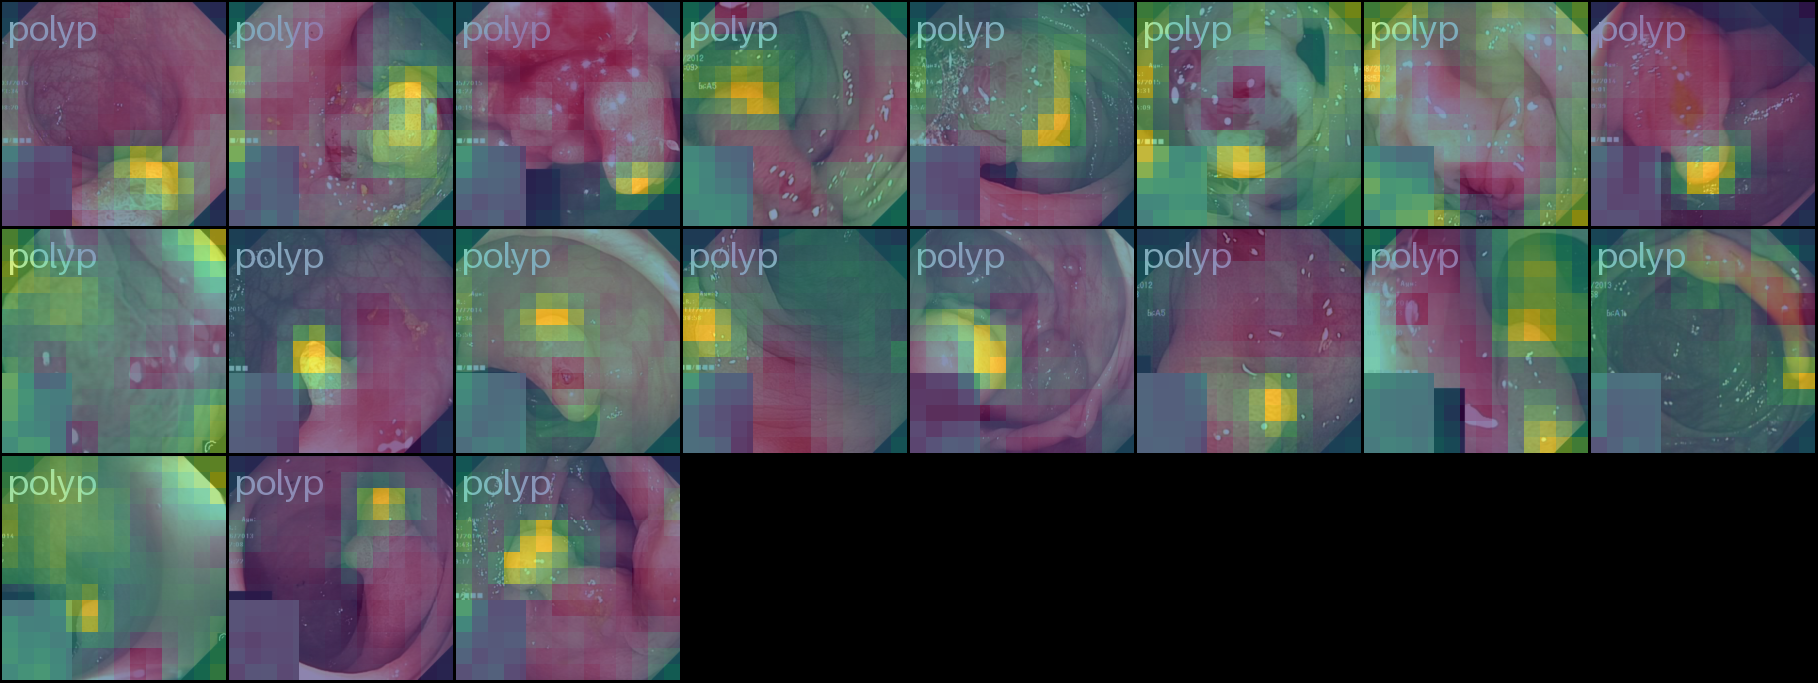

In [30]:
# img = segmentations_[0].reshape(224,224,1)
# plt.imshow(img.numpy())
from torchvision.utils import make_grid 

Grid = make_grid(polyp_images)

# display result 
img = torchvision.transforms.ToPILImage()(Grid) 
img.show() 

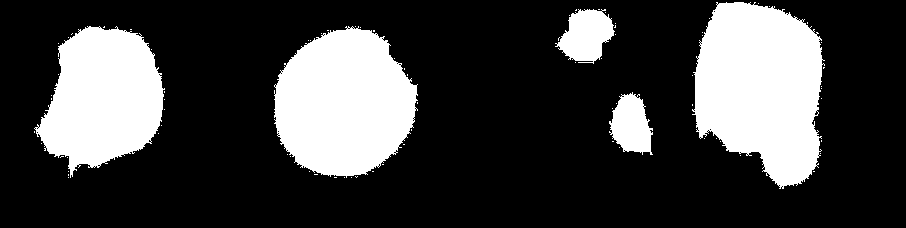

In [37]:
Grid_segm = make_grid(segmentations_[polyp_indices][4:8].float())

# display result 
img = torchvision.transforms.ToPILImage()(Grid_segm) 
img.show() 

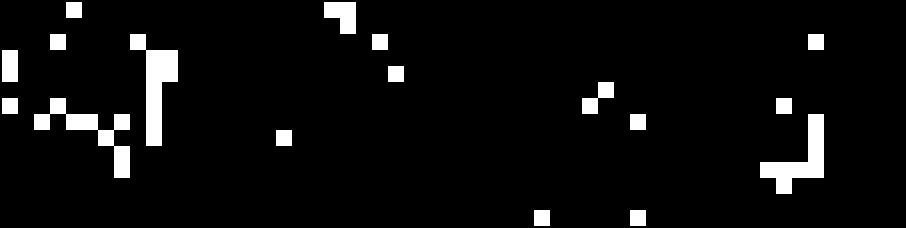

In [35]:
Grid_segm_explainer = make_grid(dice_explainer_segmentations["vit"][polyp_indices][4:8].float())

# display result 
img = torchvision.transforms.ToPILImage()(Grid_segm_explainer) 
img.show() 

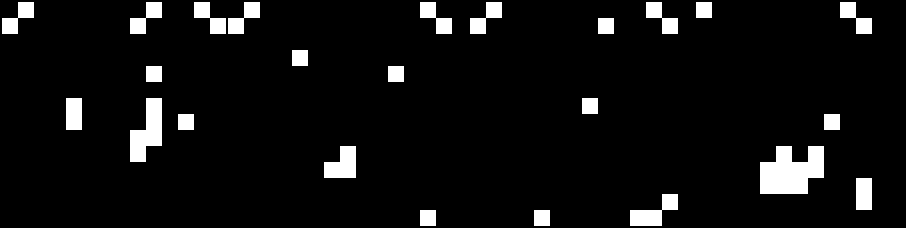

In [37]:
Grid_segm_explainer = make_grid(dice_explainer_segmentations["t2t_vit"][polyp_indices][4:8].float())

# display result 
img = torchvision.transforms.ToPILImage()(Grid_segm_explainer) 
img.show() 

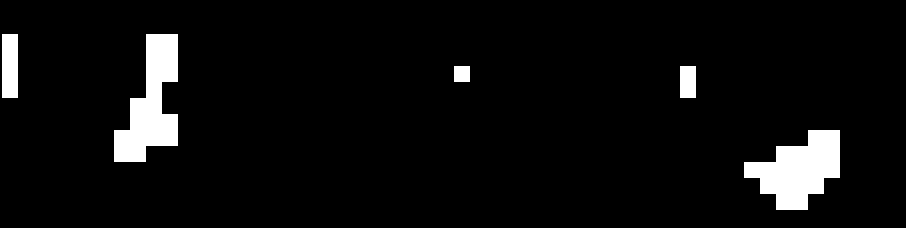

In [39]:
Grid_segm_explainer = make_grid(dice_explainer_segmentations["swin"][polyp_indices][4:8].float())

# display result 
img = torchvision.transforms.ToPILImage()(Grid_segm_explainer) 
img.show() 

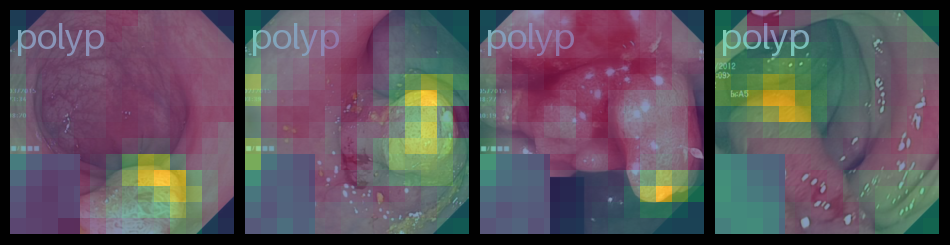

In [32]:
Grid_four_shap = make_grid(polyp_images[:4], padding=10, pad_value=1)

# display result 
img = torchvision.transforms.ToPILImage()(Grid_four_shap) 
img.show()

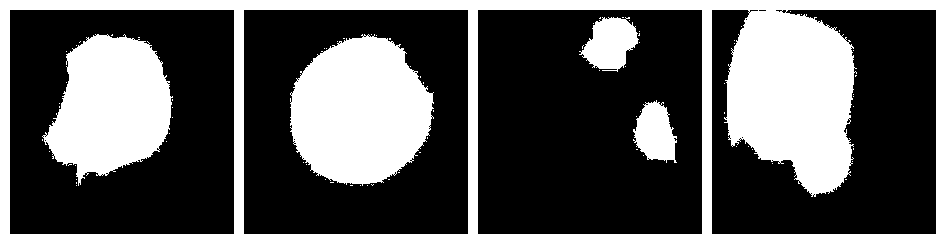

In [215]:
Grid_four_segm = make_grid(segmentations_[polyp_indices][4:8].repeat(1,3,1,1).float(), padding=10, pad_value=1)

# display result 
img = torchvision.transforms.ToPILImage()(Grid_four_segm) 
img.show()

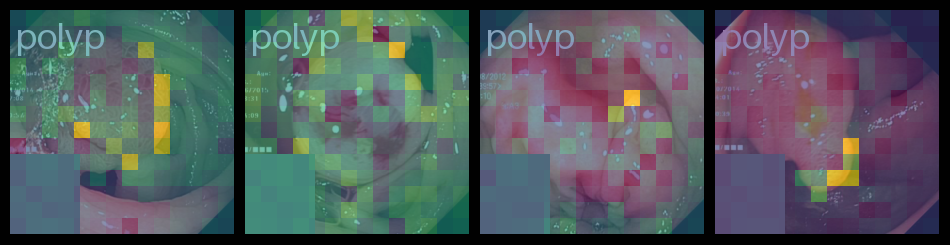

In [207]:
Grid_four_shap = make_grid(polyp_images[4:8], padding=10, pad_value=1)

# display result 
img = torchvision.transforms.ToPILImage()(Grid_four_shap) 
img.show()

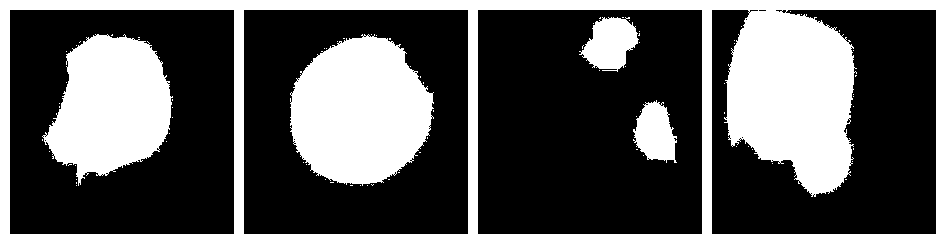

In [57]:
Grid_four_segm = make_grid(segmentations_[polyp_indices][4:8].repeat(1,3,1,1).float(), padding=10, pad_value=1)

# display result 
img = torchvision.transforms.ToPILImage()(Grid_four_segm) 
img.show()

In [ ]:
Grid_four_segm = make_grid(segmentations_[polyp_indices][4:8].repeat(1,3,1,1).float(), padding=10, pad_value=1)

# display result 
img = torchvision.transforms.ToPILImage()(Grid_four_segm) 
img.show()